# FeatureBased con todos los features (2012 al 2013)

In [1]:
from sklearn.metrics import davies_bouldin_score

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tsfeature as tsf
import entropy as ent
my_path = os.path.abspath('')
my_path = my_path.split('\\')
my_path_py = "\\".join(my_path[:-1])

In [3]:
df= pd.read_csv(my_path_py+'\\DatosRaw\\notificaciones_clima_7_dias_COMBINADO_SEMANAL.csv', sep=';')
df = df[['anio','distrito_notif', 'semana', 'casos']]
df = df[(df['anio'] == 2012) | (df['anio'] == 2013)]
poblacion= pd.read_csv(my_path_py+'\\DatosRaw\\Poblacion_Paraguay.csv', sep=',')

In [4]:
poblacion['#'] = poblacion['#'].str.upper()
poblacion = poblacion.head(268)
poblacion.rename(columns = {'#':'Ciudad'}, inplace = True)

In [5]:
print("La cantidad de ciudades con casos es:", df['distrito_notif'].nunique())
print("La cantidad de ciudades con datos de población:", poblacion['Ciudad'].nunique())

La cantidad de ciudades con casos es: 216
La cantidad de ciudades con datos de población: 266


In [6]:
S1 = set(list(dict.fromkeys(df['distrito_notif'].tolist())))
S2 = set(list(dict.fromkeys(poblacion['Ciudad'].tolist())))
ciudades = S1.intersection(S2)
df

,anio,distrito_notif,semana,casos
3614,2012,CAACUPE,1,1
3615,2012,CAPIATA,1,7
3616,2012,CONCEPCION,1,4
3617,2012,FERNANDO DE LA MORA,1,12
3618,2012,HORQUETA,1,27
...,...,...,...,...
8482,2013,VILLA HAYES,52,6
8483,2013,VILLETA,52,3
8484,2013,YAGUARON,52,1
8485,2013,YPACARAI,52,2


In [7]:
df.rename(columns = {'anio':'Año', 'distrito_notif':'Distrito'}, inplace = True)
df = df[df['Distrito'].isin(ciudades)]
listaDistrito = df['Distrito'].tolist()
listaDistrito = list(dict.fromkeys(listaDistrito))
print("La cantidad de ciudades en el periodo 2 es ", len(listaDistrito))

La cantidad de ciudades en el periodo 2 es  189


In [8]:
pob = []
for year in list(range(2012,2014)):
    aux = df[df['Año'] == year]
    for dis in aux.Distrito.values:
        pob.append(int(poblacion[poblacion.Ciudad == dis][str(year)].values[0]))   
print(len(pob))

4173


In [9]:
df['Poblacion'] = pob
df['incidencia'] = (df.casos/df.Poblacion)*100000
df['semana'] = df['semana'] + df['Año'].apply(lambda x: (x-2012)*53 if x>2012 else 0)
df.reset_index(drop=True)

<ipython-input-9-b1ee65a68305>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Poblacion'] = pob
<ipython-input-9-b1ee65a68305>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['incidencia'] = (df.casos/df.Poblacion)*100000
<ipython-input-9-b1ee65a68305>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

,Año,Distrito,semana,casos,Poblacion,incidencia
0,2012,CAACUPE,1,1,51275,1.950268
1,2012,CAPIATA,1,7,206686,3.386780
2,2012,CONCEPCION,1,4,76819,5.207045
3,2012,FERNANDO DE LA MORA,1,12,153449,7.820188
4,2012,HORQUETA,1,27,57411,47.029315
...,...,...,...,...,...,...
4168,2013,VILLA HAYES,105,6,46033,13.034128
4169,2013,VILLETA,105,3,33890,8.852169
4170,2013,YAGUARON,105,1,30369,3.292832
4171,2013,YPACARAI,105,2,25002,7.999360


In [10]:
def run_length_encoding(x):
    """
    :param x: np.array
    :return: np.array
    """
    pos, = np.where(np.diff(x) != 0)
    pos = np.concatenate(([0], pos+1, [len(x)]))
    # rle = [(a,b,x[a]) for (a,b) in zip(pos[:-1],pos[1:])]
    rle = [b - a for (a, b) in zip(pos[:-1], pos[1:])]
    return rle


def hysteresis(x, th_lo, th_hi, initial=False):
    """
    :param x: np.array
    :param th_lo: float
    :param th_hi: float
    :param initial: ???
    :return:
    """
    hi = x >= th_hi
    lo_or_hi = (x <= th_lo) | hi
    ind = np.nonzero(lo_or_hi)[0]
    # prevent index error if ind is empty
    if not ind.size:
        return np.zeros_like(x, dtype=bool) | initial
    # from 0 to len(x)
    cnt = np.cumsum(lo_or_hi)
    return np.where(cnt, hi[ind[cnt-1]], initial)


def arg_longest_not_null(x):
    # pad with np.nan while finding where null
    m = np.concatenate(( [True], np.isnan(x), [True] ))
    # Start-stop limits
    ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)
    # Get max interval, interval limits
    start, stop = ss[(ss[:,1] - ss[:,0]).argmax()]
    return start, stop

In [11]:
class poly(object):
    """ Orthogonal polynomials

    Source:
        http://davmre.github.io/python/2013/12/15/orthogonal_poly
    """

    def __init__(self):
        self.degree = None
        self.z = None
        self.norm2 = None
        self.alpha = None

    def fit(self, x, degree=1):

        self.degree = degree

        n = degree + 1
        x = np.asarray(x).flatten()
        if degree >= len(np.unique(x)):
            raise ValueError("'degree' must be less than number of unique points")

        xbar = np.mean(x)
        x = x - xbar
        q, r = np.linalg.qr(np.fliplr(np.vander(x, n)))

        z = np.diag(np.diag(r))
        raw = np.dot(q, z)

        norm2 = np.sum(raw**2, axis=0)
        alpha = (np.sum((raw**2)*np.reshape(x, (-1, 1)), axis=0)/norm2 + xbar)[:degree]
        z = raw / np.sqrt(norm2)

        self.z = z
        self.norm2 = norm2
        self.alpha = alpha

    def predict(self, x):
        x = np.asarray(x).flatten()
        n = self.degree + 1
        z = np.empty((len(x), n))
        z[:, 0] = 1

        if self.degree > 0:
            z[:, 1] = x - self.alpha[0]

        if self.degree > 1:
            for i in np.arange(1, self.degree):
                z[:, i+1] = (x - self.alpha[i]) * z[:, i] - (self.norm2[i] / self.norm2[i-1]) * z[:, i-1]

        z /= np.sqrt(self.norm2)

        return z

# Fig Func

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale as scale_data


def biplot_features(x, robust=False, scale=True,  col=None, **kwargs):
    X = x.dropna(axis=1, how='all').dropna(axis=0, how='any')

    if col is None:
        col = ("#000000", "darkred")
    else:
        col = [col] if not isinstance(col, (list, tuple)) else col
        col = np.unique(col)

        if len(col) == 1:
            col = np.repeat(col, 2)
        else:
            col = np.unique(col)[0:2]

    if scale:
        X = scale_data(X, with_mean=True, with_std=True)

    if robust:
        raise NotImplemented('Robust PCA has not been implemented yet')
    else:
        pca = PCA(n_components=2)
        pca.fit(X)
        proj_pca = pca.transform(X)

    plt.figure()
    plt.scatter(x=proj_pca[:, 0], y=proj_pca[:, 1], c=col)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

In [13]:
import statsmodels.api as sm

from statsmodels.formula.api import ols
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.stats import boxcox_normmax
from statsmodels.sandbox.gam import AdditiveModel

try:
    from entropy import spectral_entropy
except ImportError:
    ENTROPY_PACKAGE_AVAILABLE = False
else:
    ENTROPY_PACKAGE_AVAILABLE = True

# features_hyndman
# https://github.com/robjhyndman/anomalous/blob/master/R/tsmeasures.R

_VARIABLE_COUNT = 0


def trim(x, trim=0.1):
    """Trimmed time series eliminating outliers's influence"""
    qtl = x.quantile([trim, 1 - trim])
    lo = qtl.iloc[0]
    hi = qtl.iloc[1]

    trim_x = x.copy()
    trim_x[(trim_x < lo) | (trim_x > hi)] = np.nan
    return trim_x


def first_order_autocorrelation(x):
    """First order of autocorrelation"""
    return x.autocorr(1)


def lumpiness(x, width):
    """Lumpiness

    Note:
        Cannot be used for yearly data
    """
    nr = len(x)
    start = np.arange(1, nr, step=width, dtype=int)
    end = np.arange(width, nr + width, step=width, dtype=int)

    nsegs = int(nr / width)

    varx = np.zeros(nsegs)

    for idx in range(nsegs):
        tmp = x[start[idx]:end[idx]]
        varx[idx] = tmp[~np.isnan(tmp)].var()

    lump = varx[~np.isnan(varx)].var()
    return lump


def rolling_level_shift(x, width):
    """Level shift

    Using rolling window
    """

    tmp = x.dropna()
    roll_mean = tmp.rolling(width).mean()

    try:
        level_shifts = roll_mean.diff(width).abs().max()
    except Exception:
        level_shifts = np.nan

    return level_shifts


def rolling_variance_change(x, width):
    """Variance change

    Using rolling window

    """
    tmp = x.dropna()

    roll_var = tmp.rolling(width).var()

    try:
        variance_change = roll_var.diff(width).abs().max()
    except Exception:
        variance_change = np.nan

    return variance_change


def n_crossing_points(x):
    """Number of crossing points"""
    mid_line = ((x.max() - x.min()) / 2.0)
    ab = (x <= mid_line).values
    len_x = len(x)
    p1 = ab[1:(len_x - 1)]
    p2 = ab[2:len_x]
    cross = (p1 & ~p2) | (p2 & ~p1)
    return cross.sum()


def flat_spots(x):
    """Flat spots using discretization"""

    try:
        cut_x = pd.cut(x, bins=10, include_lowest=True, labels=False)
        rle_x = run_length_encoding(cut_x)
        spots = max(rle_x)
    except Exception:
        spots = np.nan

    #  Any flat spot
    return spots


def trend_seasonality_spike_strength(x, freq):
    """Strength of trend and seasonality and spike"""
    cont_x = x.dropna()
    length_cont_x = len(cont_x)
    season = peak = trough = np.nan

    if length_cont_x < (2 * freq):
        trend = linearity = curvature = season = spike = peak = trough = np.nan
    else:

        if freq > 1:
            all_stl = sm.tsa.seasonal_decompose(cont_x, period=freq)
            trend0 = all_stl.trend
            fits = trend0 + all_stl.seasonal
            adj_x = cont_x - fits
            v_adj = adj_x.var()
            detrend = cont_x - trend0
            deseason = cont_x - all_stl.seasonal
            peak = all_stl.seasonal.max()
            trough = all_stl.seasonal.min()
            remainder = all_stl.resid
            season = 0 if detrend.var() < 1e-10 else max(0, min(1, 1 - v_adj/detrend.var()))

        else:  # No seasonal component
            tt = np.array([range(length_cont_x)]).T

            _trend0_values = AdditiveModel(tt).fit(cont_x.values).mu
            trend0=pd.Series(_trend0_values, index=cont_x.index)
            remainder = cont_x - trend0
            deseason = cont_x - trend0
            v_adj = trend0.var()

        trend = 0 if deseason.var() < 1e-10 else max(0, min(1, 1 - v_adj/deseason.var()))

        n = len(remainder)
        v = remainder.var()
        d = (remainder - remainder.mean())**2
        varloo = (v * (n - 1) - d) / (n - 2)
        spike = varloo.var()
        pl = poly()
        pl.fit(range(length_cont_x), degree=2)
        result_pl = pl.predict(range(length_cont_x))  # [:, 2]

        X = sm.add_constant(result_pl, has_constant='add')
        ols_data = trend0.copy()
        ols_data = pd.concat([ols_data.reset_index(drop=True), pd.DataFrame(X)], axis=1, ignore_index=True)
        ols_data.columns = ['Y', 'Intercept', 'X1', 'X2', 'X3']
        result_ols = ols('Y ~ X1 + X2 + X3', data=ols_data.dropna())

        trend_coef = result_ols.fit().params
        linearity = trend_coef[1]
        curvature = trend_coef[2]

    result = dict(trend=trend, spike=spike, peak=peak, trough=trough, linearity=linearity, curvature=curvature)

    if freq > 1:
        result["season"] = season

    return result


def kullback_leibler_score(x, window, threshold=None):
    """Kullback-Leibler score"""

    if threshold is None:
        threshold = norm.pdf(38)

    gw = 100  # grid width
    xgrid = np.arange(x.min(), x.max(), step=(x.max() - x.min()) / gw, dtype=float)
    grid = xgrid[1] - xgrid[0]
    tmpx = x[~x.isnull()]  # Remove NA to calculate bw
    bw = gaussian_kde(tmpx).covariance_factor()
    len_x = len(x)

    if len_x <= (2 * window):
        raise ValueError("Cannot compute KLscore when the length is too small.")

    dens_mat = np.zeros((len_x, gw))

    for i in range(len_x):
        dens_mat[i, :] = norm.pdf(xgrid, x[i], bw)

    dens_mat = np.clip(dens_mat, threshold, None)

    rmean = dens_mat.rolling(window=window).mean()

    lo = range(len_x - window + 1)
    hi = range(window + 1, len_x)
    seqidx = min(len(lo), len(hi))

    kl = np.zeros(seqidx)
    for i in range(seqidx):
        kl[i] = np.sum(rmean[lo[i], ] * (np.log(rmean[lo[i], ]) - np.log(rmean[hi[i], ])) * grid)

    diffkl = pd.Series(kl).dropna().diff()
    maxidx = np.argmax(diffkl)

    return dict(score=np.max(diffkl), change_idx=maxidx)


def boxcox_optimal_lambda(x):
    y = x + 0.0000001 if np.any(x == 0) else x
    return boxcox_normmax(y)


# TODO: implement Spectral Entropy
def entropy(x, freq=1, normalize=False):
    """
    Spectral Entropy
    """
    try:
        start, stop = arg_longest_not_null(x)
        result = spectral_entropy(x[start:stop], sf=freq, method='welch', normalize=normalize)
    except Exception:
        result = np.nan
    finally:
        return result


def ts_measures(x, freq=1, normalize=True, width=None, window=None):
    """
    See `ts_measures_series` doc
    """

    if isinstance(x, pd.Series):
        measures_df = ts_measures_series(x, freq=freq, normalize=normalize, width=width, window=window)
    elif isinstance(x, pd.DataFrame):
        _buffer = []
        for c in x.columns:
            _buffer.append(ts_measures_series(x[c], freq=freq, normalize=normalize, width=width, window=window))
        measures_df = pd.concat(_buffer, axis=0)

    elif issubclass(x.__class__, pd.core.groupby._GroupBy):
        _buffer = []
        for i in x.groups:
            _buffer.append(ts_measures(x.get_group(i), freq=freq, normalize=normalize, width=width, window=window))

        measures_df = pd.concat(_buffer, axis=0)
    else:
        raise TypeError('Unhandled input type')

    return measures_df


def ts_measures_series(x, freq=1, normalize=True, width=None, window=None):
    """
    :param x: a uni-variate time series
    :param freq: number of points to be considered as part of a single period for trend_seasonality_spike_strength
    :param normalize: TRUE: scale data to be normally distributed
    :param width: a window size for variance change and level shift, lumpiness
    :param window: a window size for KLscore
    :return:
    """
    name = x.name

    if width is None:
        width = freq if freq > 1 else 10

    if window is None:
        window = width

    if (width <= 1) | (window <= 1):
        raise ValueError("Window widths should be greater than 1.")

    # Remove columns containing all NAs
    if x.isnull().all():
        raise ValueError("All values are null")

    if normalize:
        x = (x - np.min(x)) / (np.max(x) - np.min(x))

    trimx = trim(x)

    measures = dict()
    measures['lumpiness'] = lumpiness(x, width=width)
    if ENTROPY_PACKAGE_AVAILABLE:
        measures['entropy'] = entropy(x, freq=freq, normalize=False)
    measures['ACF1'] = first_order_autocorrelation(x)
    measures['lshift'] = rolling_level_shift(trimx, width=width)
    measures['vchange'] = rolling_variance_change(trimx, width=width)
    measures['cpoints'] = n_crossing_points(x)
    measures['fspots'] = flat_spots(x)
    #  measures['mean'] = np.mean(x)
    #  measures['var'] = np.var(x)

    varts = trend_seasonality_spike_strength(x, freq=freq)
    measures['trend'] = varts['trend']
    measures['linearity'] = varts['linearity']
    measures['curvature'] = varts['curvature']
    measures['spikiness'] = varts['spike']

    if freq > 1:
        measures['season'] = varts['season']
        measures['peak'] = varts['peak']
        measures['trough'] = varts['trough']

    threshold = norm.pdf(38)

    try:
        kl = kullback_leibler_score(x, window=window, threshold=threshold)
        measures['KLscore'] = kl['score']
        measures['change_idx'] = kl['change_idx']
    except Exception:
        measures['KLscore'] = np.nan
        measures['change_idx'] = np.nan

    measures['boxcox'] = boxcox_optimal_lambda(x)

    # Build output
    measures_df = pd.Series(measures).to_frame().transpose()
    measures_df.index = [x.index.min()] if isinstance(x, pd.Series) else [0]
    measures_df['variable'] = name if name is not None else generate_name()
    return measures_df

def generate_name(prefix='var_'):
    global _VARIABLE_COUNT
    output = "{}{}".format(prefix, _VARIABLE_COUNT)
    _VARIABLE_COUNT += 1
    return output

In [14]:
ENTROPY_PACKAGE_AVAILABLE

False

In [15]:
i=0
df1 = df[['Distrito','semana', 'incidencia']]
for dis in listaDistrito:
    df1.loc[df1['Distrito']==dis,'ID_distrito']=i
    i=i+1
df1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Distrito,semana,incidencia,ID_distrito
3614,CAACUPE,1,1.950268,0.0
3615,CAPIATA,1,3.386780,1.0
3616,CONCEPCION,1,5.207045,2.0
3617,FERNANDO DE LA MORA,1,7.820188,3.0
3618,HORQUETA,1,47.029315,4.0
...,...,...,...,...
8482,VILLA HAYES,105,13.034128,65.0
8483,VILLETA,105,8.852169,15.0
8484,YAGUARON,105,3.292832,41.0
8485,YPACARAI,105,7.999360,35.0


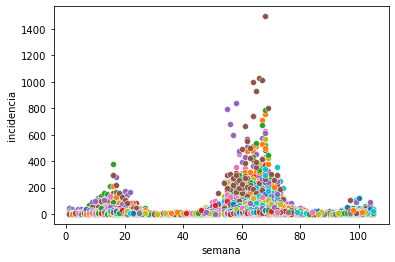

In [16]:
timeSeries = pd.DataFrame()
#listaDistrito = listaDistrito[0:15]
for dis in listaDistrito:
    distrito=df[df['Distrito']==dis]
    distrito.sort_values(['semana'], ascending = True)
    distrito = distrito.reset_index(drop=True)
    distrito = distrito.replace('nan', np.nan).fillna(0.00000000001)
    distrito = distrito.replace([np.inf, -np.inf], np.nan).fillna(0.00000000001)
    timeSeries = timeSeries.append(distrito['incidencia'], ignore_index=True)
    #print(dis)
    ax = sns.scatterplot(y=distrito['incidencia'], x= distrito['semana'])
plt.show()

In [17]:
import tsfresh
from tsfresh import extract_features

#features extraction
extracted_features = extract_features(df1, column_id='ID_distrito', column_sort='semana', column_value='incidencia')

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 19/19 [00:09<00:00,  1.96it/s]


In [18]:
timeSeries = timeSeries.replace('nan', np.nan).fillna(0.00000000001)
timeSeries = timeSeries.replace([np.inf, -np.inf], np.nan).fillna(0.00000000001)

In [19]:
#from tsfeatures import tsfeatures
df2 = df1[['ID_distrito', 'incidencia', 'semana']]
df2 = df2.reset_index(drop=True)
df2.rename(columns = {'ID_distrito':'unique_id', 'incidencia':'y', 'semana':'ds'}, inplace = True)

In [20]:
y = ts_measures(timeSeries.T, freq=4)
y.insert(0, "Distrito", listaDistrito, allow_duplicates=False)

In [21]:
y = y.fillna(0.0000000001)

In [22]:
features = pd.DataFrame()
Mean=[]
Var=[]
aCF1=[]
Trend=[]
Linearity=[]
Curvature=[]
Season=[]
Peak=[]
Trough=[]
Entropy=[]
Lumpiness=[]
Spikiness=[]
Lshift=[]
Vchange=[]
Fspots=[]
Cpoints_=[]
Klscore=[]
ChangeIdx=[]

for dis in listaDistrito:
    distrito_1=df['Distrito']==dis
    casos_distrito1=df[distrito_1]
    casos_distrito1 = casos_distrito1.reset_index(drop=True)
    casos_distrito1 = casos_distrito1['incidencia']
    casos_distrito1 = casos_distrito1.replace('nan', np.nan).fillna(0.00000000001)
    casos_distrito1 = casos_distrito1.replace(0, np.nan).fillna(0.00000000001)
    casos_distrito1 = casos_distrito1.replace([np.inf, -np.inf], np.nan).fillna(0.00000000001)
    
    #Features
    mean= tsfresh.feature_extraction.feature_calculators.mean(casos_distrito1)
    var=tsfresh.feature_extraction.feature_calculators.variance(casos_distrito1)
    ACF1=tsfresh.feature_extraction.feature_calculators.autocorrelation(casos_distrito1,1)
    trend = y[y["Distrito"] == dis].trend
    linear = y[y["Distrito"] == dis].linearity
    curv = y[y["Distrito"] == dis].curvature
    season = y[y["Distrito"] == dis].season
    peak = tsfresh.feature_extraction.feature_calculators.number_peaks(casos_distrito1, int(mean))
    trough_ = y[y["Distrito"] == dis].trough
    entropy = tsfresh.feature_extraction.feature_calculators.sample_entropy(casos_distrito1)
    lump = y[y["Distrito"] == dis].lumpiness
    spik = y[y["Distrito"] == dis].spikiness
    lshift = y[y["Distrito"] == dis].lshift
    vchange = y[y["Distrito"] == dis].vchange
    fspots = y[y["Distrito"] == dis].fspots
    cpoints_ = y[y["Distrito"] == dis].cpoints
    klscore = y[y["Distrito"] == dis].KLscore
    changeidx = y[y["Distrito"] == dis].change_idx
    
    Mean.append(mean)
    Var.append(var)
    aCF1.append(ACF1)
    Trend.append(trend[0])
    Linearity.append(linear[0])
    Curvature.append(curv[0])
    Season.append(season[0])
    Peak.append(peak)
    Trough.append(trough_[0])
    Entropy.append(entropy)
    Lumpiness.append(lump[0])
    Spikiness.append(spik[0])
    Lshift.append(lshift[0])
    Vchange.append(vchange[0])
    Fspots.append(fspots[0])
    Cpoints_.append(cpoints_)
    Klscore.append(klscore[0])
    ChangeIdx.append(changeidx[0])

C:\Users\gioma\AppData\Roaming\Python\Python38\site-packages\tsfresh\feature_extraction\feature_calculators.py:1734: RuntimeWarning: invalid value encountered in long_scalars
  return -np.log(A / B)
C:\Users\gioma\AppData\Roaming\Python\Python38\site-packages\tsfresh\feature_extraction\feature_calculators.py:1734: RuntimeWarning: invalid value encountered in long_scalars
  return -np.log(A / B)
C:\Users\gioma\AppData\Roaming\Python\Python38\site-packages\tsfresh\feature_extraction\feature_calculators.py:1734: RuntimeWarning: invalid value encountered in long_scalars
  return -np.log(A / B)
C:\Users\gioma\AppData\Roaming\Python\Python38\site-packages\tsfresh\feature_extraction\feature_calculators.py:1734: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
C:\Users\gioma\AppData\Roaming\Python\Python38\site-packages\tsfresh\feature_extraction\feature_calculators.py:1734: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
C:\Users\gioma\AppDat

C:\Users\gioma\AppData\Roaming\Python\Python38\site-packages\tsfresh\feature_extraction\feature_calculators.py:1734: RuntimeWarning: invalid value encountered in double_scalars
  return -np.log(A / B)
C:\Users\gioma\AppData\Roaming\Python\Python38\site-packages\tsfresh\feature_extraction\feature_calculators.py:1734: RuntimeWarning: invalid value encountered in long_scalars
  return -np.log(A / B)
C:\Users\gioma\AppData\Roaming\Python\Python38\site-packages\tsfresh\feature_extraction\feature_calculators.py:1734: RuntimeWarning: invalid value encountered in long_scalars
  return -np.log(A / B)
C:\Users\gioma\AppData\Roaming\Python\Python38\site-packages\tsfresh\feature_extraction\feature_calculators.py:1734: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
C:\Users\gioma\AppData\Roaming\Python\Python38\site-packages\tsfresh\feature_extraction\feature_calculators.py:1734: RuntimeWarning: invalid value encountered in double_scalars
  return -np.log(A / B)
C:\Users\

In [23]:
data_tuples = list(zip(Mean, Var, aCF1, Trend, Linearity, Curvature, Season, Peak, Trough, Entropy, Lumpiness, Spikiness, Lshift, Vchange, Fspots, Cpoints_, Klscore, ChangeIdx))
features = pd.DataFrame(data_tuples, columns =['Mean', 'Var', 'ACF1','Trend', 'Linearity', 'Curvature', 'Season', 'Peak', 'Trough', 'Entropy', 'Lumpiness','Spikiness','Lshift', 'Vchange','Fspots', 'Cpoints', 'KlScore', 'ChangeIdx']) 

# print the data 
features

,Mean,Var,ACF1,Trend,Linearity,Curvature,Season,Peak,Trough,Entropy,Lumpiness,Spikiness,Lshift,Vchange,Fspots,Cpoints,KlScore,ChangeIdx
0,30.791765,1442.218018,0.815680,0.888300,0.011685,-0.729854,0.030544,0,-0.019223,0.498046,0.000106,2.372003e-08,0.196023,0.015496,40.0,"0 6.0 Name: cpoints, dtype: float64",1.000000e-10,1.000000e-10
1,79.770214,20817.368246,0.919189,0.935744,0.009866,0.282462,0.048573,0,-0.015372,0.170604,0.000382,6.886434e-09,0.242339,0.014883,35.0,"0 4.0 Name: cpoints, dtype: float64",1.000000e-10,1.000000e-10
2,22.863663,656.719511,0.770336,0.858252,0.012863,-1.205402,0.050068,0,-0.016318,0.407368,0.000683,1.732605e-08,0.250000,0.015152,48.0,"0 8.0 Name: cpoints, dtype: float64",1.000000e-10,1.000000e-10
3,65.928702,6667.912864,0.928110,0.949092,0.016444,-0.014662,0.051392,0,-0.016431,0.213202,0.000106,3.123768e-09,0.348139,0.032118,28.0,"0 10.0 Name: cpoints, dtype: float64",1.000000e-10,1.000000e-10
4,16.081299,305.790074,0.835112,0.919623,0.013560,-1.704199,0.109310,1,-0.027727,0.495134,0.000610,2.376255e-08,0.209459,0.017288,49.0,"0 7.0 Name: cpoints, dtype: float64",1.000000e-10,1.000000e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,56.497175,0.000000,NaN,0.984210,0.000145,-0.022734,0.030303,0,-0.003750,NaN,0.000000,1.991513e-10,0.000000,0.000000,103.0,"0 0.0 Name: cpoints, dtype: float64",1.000000e-10,1.000000e-10
185,22.393909,62.685894,-0.250000,0.962554,0.000724,-0.112523,0.037249,0,-0.006250,NaN,0.000257,1.206422e-09,0.000000,0.000000,101.0,"0 0.0 Name: cpoints, dtype: float64",1.000000e-10,1.000000e-10
186,13.968431,0.000000,NaN,0.919781,0.000580,-0.090477,0.024390,0,-0.010000,NaN,0.004109,1.629108e-08,0.000000,0.000000,102.0,"0 1.0 Name: cpoints, dtype: float64",1.000000e-10,1.000000e-10
187,13.154433,0.000000,NaN,0.984210,0.000145,-0.022734,0.030303,0,-0.003750,NaN,0.000000,1.991513e-10,0.000000,0.000000,103.0,"0 0.0 Name: cpoints, dtype: float64",1.000000e-10,1.000000e-10


In [24]:
features = features.replace('nan', np.nan).fillna(0.00000001)
features = features.replace(0, np.nan).fillna(0.0000001)
features = features.replace([np.inf, -np.inf], np.nan).fillna(0.00000001)
for col in features.columns:
    features[col] = features[col].astype(float)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\missing.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


In [25]:
features.insert(0, 'Distrito', y.Distrito.values)
features

,Distrito,Mean,Var,ACF1,Trend,Linearity,Curvature,Season,Peak,Trough,Entropy,Lumpiness,Spikiness,Lshift,Vchange,Fspots,Cpoints,KlScore,ChangeIdx
0,CAACUPE,30.791765,1.442218e+03,8.156804e-01,0.888300,0.011685,-0.729854,0.030544,1.000000e-07,-0.019223,4.980459e-01,1.060359e-04,2.372003e-08,1.960227e-01,1.549587e-02,40.0,6.0,1.000000e-10,1.000000e-10
1,CAPIATA,79.770214,2.081737e+04,9.191889e-01,0.935744,0.009866,0.282462,0.048573,1.000000e-07,-0.015372,1.706044e-01,3.820085e-04,6.886434e-09,2.423390e-01,1.488347e-02,35.0,4.0,1.000000e-10,1.000000e-10
2,CONCEPCION,22.863663,6.567195e+02,7.703363e-01,0.858252,0.012863,-1.205402,0.050068,1.000000e-07,-0.016318,4.073681e-01,6.831052e-04,1.732605e-08,2.500000e-01,1.515152e-02,48.0,8.0,1.000000e-10,1.000000e-10
3,FERNANDO DE LA MORA,65.928702,6.667913e+03,9.281097e-01,0.949092,0.016444,-0.014662,0.051392,1.000000e-07,-0.016431,2.132018e-01,1.056129e-04,3.123768e-09,3.481388e-01,3.211782e-02,28.0,10.0,1.000000e-10,1.000000e-10
4,HORQUETA,16.081299,3.057901e+02,8.351115e-01,0.919623,0.013560,-1.704199,0.109310,1.000000e+00,-0.027727,4.951343e-01,6.101401e-04,2.376255e-08,2.094595e-01,1.728756e-02,49.0,7.0,1.000000e-10,1.000000e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,DESMOCHADOS,56.497175,1.000000e-07,1.000000e-08,0.984210,0.000145,-0.022734,0.030303,1.000000e-07,-0.003750,1.000000e-08,1.000000e-07,1.991513e-10,1.000000e-07,1.000000e-07,103.0,0.0,1.000000e-10,1.000000e-10
185,CORONEL MARTINEZ,22.393909,6.268589e+01,-2.500000e-01,0.962554,0.000724,-0.112523,0.037249,1.000000e-07,-0.006250,1.000000e-08,2.568212e-04,1.206422e-09,1.000000e-07,1.000000e-07,101.0,0.0,1.000000e-10,1.000000e-10
186,SANTA ROSA DEL MONDAY,13.968431,1.000000e-07,1.000000e-08,0.919781,0.000580,-0.090477,0.024390,1.000000e-07,-0.010000,1.000000e-08,4.109139e-03,1.629108e-08,1.000000e-07,1.000000e-07,102.0,1.0,1.000000e-10,1.000000e-10
187,NUEVA ALBORADA,13.154433,1.000000e-07,1.000000e-08,0.984210,0.000145,-0.022734,0.030303,1.000000e-07,-0.003750,1.000000e-08,1.000000e-07,1.991513e-10,1.000000e-07,1.000000e-07,103.0,0.0,1.000000e-10,1.000000e-10


In [26]:
features.to_csv('FB2_2012-2013.csv')

In [27]:
n= timeSeries.shape[0]
n

189

# Funciones de Distancias

In [28]:
import math
from math import sqrt, log, floor
from sklearn.metrics import mean_squared_error
from statistics import mean
from fastdtw import fastdtw
from scipy import stats
from scipy.spatial.distance import pdist

#Euclidean
def euclidean(x, y):
    r=np.linalg.norm(x-y)
    if math.isnan(r):
        r=1
    #print(r)
    return r

#Fast Dynamic time warping
def fast_DTW(x, y):
    r, _ = fastdtw(x, y, dist=euclidean)
    if math.isnan(r):
        r=1
    #print(r)
    return r

#Spearman
def scorr(x, y):
    r = stats.spearmanr(x, y)[0]
    if math.isnan(r):
        r=0
    #print(r)
    return 1 - r

#RMSE
def rmse(x, y):
    r=sqrt(mean_squared_error(x,y))
    if math.isnan(r):
        r=1
    #print(r)
    return r

def lcs(a, b):  
    lengths = [[0 for j in range(len(b)+1)] for i in range(len(a)+1)]
    # row 0 and column 0 are initialized to 0 already
    for i, x in enumerate(a):
        for j, y in enumerate(b):
            if x == y:
                lengths[i+1][j+1] = lengths[i][j] + 1
            else:
                lengths[i+1][j+1] = max(lengths[i+1][j], lengths[i][j+1])
    x, y = len(a), len(b)
    result = lengths[x][y]
    return result

def discretise(x):
    return int(x * 10)

def multidim_lcs(a, b):
    a = a.applymap(discretise)
    b = b.applymap(discretise)
    rows, dims = a.shape
    lcss = [lcs(a[i+2], b[i+2]) for i in range(dims)]
    return 1 - sum(lcss) / (rows * dims)

#Correlation
def corr(x, y):
    r=np.dot(x-mean(x),y-mean(y))/((np.linalg.norm(x-mean(x)))*(np.linalg.norm(y-mean(y))))
    if math.isnan(r):
        r=0
    #print(r)
    return 1 - r

In [29]:
from sklearn.preprocessing import LabelEncoder
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score

DIAMETER_METHODS = ['mean_cluster', 'farthest']
CLUSTER_DISTANCE_METHODS = ['nearest', 'farthest']

def inter_cluster_distances(labels, distances, method='nearest'):
    """Calculates the distances between the two nearest points of each cluster.
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: `nearest` for the distances between the two nearest points in each cluster, or `farthest`
    """
    if method not in CLUSTER_DISTANCE_METHODS:
        raise ValueError(
            'method must be one of {}'.format(CLUSTER_DISTANCE_METHODS))

    if method == 'nearest':
        return __cluster_distances_by_points(labels, distances)
    elif method == 'farthest':
        return __cluster_distances_by_points(labels, distances, farthest=True)


def __cluster_distances_by_points(labels, distances, farthest=False):
    n_unique_labels = len(np.unique(labels))
    cluster_distances = np.full((n_unique_labels, n_unique_labels),
                                float('inf') if not farthest else 0)

    np.fill_diagonal(cluster_distances, 0)

    for i in np.arange(0, len(labels) - 1):
        for ii in np.arange(i, len(labels)):
            if labels[i] != labels[ii] and (
                (not farthest and
                 distances[i, ii] < cluster_distances[labels[i], labels[ii]])
                    or
                (farthest and
                 distances[i, ii] > cluster_distances[labels[i], labels[ii]])):
                cluster_distances[labels[i], labels[ii]] = cluster_distances[
                    labels[ii], labels[i]] = distances[i, ii]
    return cluster_distances


def diameter(labels, distances, method='farthest'):
    """Calculates cluster diameters
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: either `mean_cluster` for the mean distance between all elements in each cluster, or `farthest` for the distance between the two points furthest from each other
    """
    if method not in DIAMETER_METHODS:
        raise ValueError('method must be one of {}'.format(DIAMETER_METHODS))

    n_clusters = len(np.unique(labels))
    diameters = np.zeros(n_clusters)

    if method == 'mean_cluster':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii]:
                    diameters[labels[i]] += distances[i, ii]

        for i in range(len(diameters)):
            diameters[i] /= sum(labels == i)

    elif method == 'farthest':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii] and distances[i, ii] > diameters[
                        labels[i]]:
                    diameters[labels[i]] = distances[i, ii]
    return diameters

def dunn(labels, distances, diameter_method='farthest',
         cdist_method='nearest'):
    """
    Dunn index for cluster validation (larger is better).
    
    .. math:: D = \\min_{i = 1 \\ldots n_c; j = i + 1\ldots n_c} \\left\\lbrace \\frac{d \\left( c_i,c_j \\right)}{\\max_{k = 1 \\ldots n_c} \\left(diam \\left(c_k \\right) \\right)} \\right\\rbrace
    
    where :math:`d(c_i,c_j)` represents the distance between
    clusters :math:`c_i` and :math:`c_j`, and :math:`diam(c_k)` is the diameter of cluster :math:`c_k`.
    Inter-cluster distance can be defined in many ways, such as the distance between cluster centroids or between their closest elements. Cluster diameter can be defined as the mean distance between all elements in the cluster, between all elements to the cluster centroid, or as the distance between the two furthest elements.
    The higher the value of the resulting Dunn index, the better the clustering
    result is considered, since higher values indicate that clusters are
    compact (small :math:`diam(c_k)`) and far apart (large :math:`d \\left( c_i,c_j \\right)`).
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param diameter_method: see :py:function:`diameter` `method` parameter
    :param cdist_method: see :py:function:`diameter` `method` parameter
    
    .. [Kovacs2005] Kovács, F., Legány, C., & Babos, A. (2005). Cluster validity measurement techniques. 6th International Symposium of Hungarian Researchers on Computational Intelligence.
    """

    labels = LabelEncoder().fit(labels).transform(labels)
    
    

    ic_distances = inter_cluster_distances(labels, distances, cdist_method)
    #print("IC",ic_distances)
    if len(ic_distances[ic_distances.nonzero()])==0:
        min_distance = 0
    else:
        min_distance = min(ic_distances[ic_distances.nonzero()])
    max_diameter = max(diameter(labels, distances, diameter_method))
    
    

    return min_distance / max_diameter

In [30]:
features = features.replace('nan', np.nan).fillna(0.00001)

In [31]:
features = features.drop('Distrito', axis=1)

In [32]:
print('Cantidad de nan: ', features.isnull().values.any()) 
#print('Cantidad de inf: ', np.isinf(features).values.sum() ) 

Cantidad de nan:  False


In [34]:
import matplotlib.pyplot as plt
k=6

#Euclidean
f_euclidean_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(1,n):
         f_euclidean_dist[i,j] = euclidean(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())

#Corr
corr_dist = np.zeros((n,n))
for i in range(0,n):
    for j in range(0,n):
            corr_dist[i,j] = corr(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())

#scorr
f_scorr_dist = np.zeros((n,n))
for i in range(0,n):
    for j in range(0,n):
        f_scorr_dist[i,j] = scorr(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())
#DTW
f_dtw_dist = np.zeros((n,n))
for i in range(0,n):
    for j in range(0,n):
        f_dtw_dist[i,j] = fast_DTW(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())
    

In [35]:
#Experimentos HAC
HAC_EUCLIDEAN=[]
HAC_CORRELATION=[]
HAC_SPEARMAN=[]
HAC_DTW=[]

HAC_EUCLIDEAN_CHZ=[]
HAC_CORRELATION_CHZ=[]
HAC_SPEARMAN_CHZ=[]
HAC_DTW_CHZ=[]

HAC_EUCLIDEAN_DUNN=[]
HAC_CORRELATION_DUNN=[]
HAC_SPEARMAN_DUNN=[]
HAC_DTW_DUNN=[]

HAC_EUCLIDEAN_DAVID=[]
HAC_CORRELATION_DAVID=[]
HAC_SPEARMAN_DAVID=[]
HAC_DTW_DAVID=[]

HAC_euc = AgglomerativeClustering(n_clusters=k).fit_predict(f_euclidean_dist)
print("HAC + euclidian distance: ")
sil = silhouette_score(f_euclidean_dist, HAC_euc)
print("SC: ", sil)
chz = calinski_harabasz_score(f_euclidean_dist, HAC_euc)
print("CHZ: ", chz)
dunn_= dunn(HAC_euc, f_euclidean_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
david_= davies_bouldin_score(f_euclidean_dist, HAC_euc)
print("DAV-BOUD: ", david_)
HAC_EUCLIDEAN.append(sil)
HAC_EUCLIDEAN_CHZ.append(chz)
HAC_EUCLIDEAN_DUNN.append(dunn_)
HAC_EUCLIDEAN_DAVID.append(david_)

HAC_corr = AgglomerativeClustering(n_clusters=k).fit_predict(corr_dist)
print("HAC + corr distance: ")
sil = silhouette_score(corr_dist, HAC_corr)
print("SC: ", sil)
chz = calinski_harabasz_score(corr_dist, HAC_corr)
print("CHZ: ", chz)
dunn_ = dunn(HAC_corr, corr_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
david_= davies_bouldin_score(corr_dist, HAC_corr)
print("DAV-BOUD: ", david_)
HAC_CORRELATION.append(sil)
HAC_CORRELATION_CHZ.append(chz)
HAC_CORRELATION_DUNN.append(dunn_)
HAC_CORRELATION_DAVID.append(david_)

HAC_scorr = AgglomerativeClustering(n_clusters=k).fit_predict(f_scorr_dist)
print("HAC + scorr distance: ")
sil = silhouette_score(f_scorr_dist, HAC_scorr)
print("SC: ", sil)
chz = calinski_harabasz_score(f_scorr_dist, HAC_scorr)
print("CHZ: ", chz)
dunn_ = dunn(HAC_scorr, f_scorr_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
david_= davies_bouldin_score(f_scorr_dist, HAC_scorr)
print("DAV-BOUD: ", david_)
HAC_SPEARMAN.append(sil)
HAC_SPEARMAN_CHZ.append(chz)
HAC_SPEARMAN_DUNN.append(dunn_)
HAC_SPEARMAN_DAVID.append(david_)

HAC_dtw = AgglomerativeClustering(n_clusters=k).fit_predict(f_dtw_dist)
print("HAC + dtw distance: ")
sil = silhouette_score(f_dtw_dist, HAC_dtw)
print("SC: ", sil)
chz = calinski_harabasz_score(f_dtw_dist, HAC_dtw)
print("CHZ: ", chz)
dunn_ = dunn(HAC_dtw, f_dtw_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
david_= davies_bouldin_score(f_dtw_dist, HAC_dtw)
print("DAV-BOUD: ", david_)
HAC_DTW.append(sil)
HAC_DTW_CHZ.append(chz)
HAC_DTW_DUNN.append(dunn_)
HAC_DTW_DAVID.append(david_)
print("-----------------------")

HAC + euclidian distance: 
SC:  0.8299960642320671
CHZ:  3534.6019055419647
DUNN:  0.8267300338586647
DAV-BOUD:  0.3719875609617893
HAC + corr distance: 
SC:  0.6121544448567801
CHZ:  1821.9508965468794
DUNN:  2.418123693955534
DAV-BOUD:  0.4851853047865901
HAC + scorr distance: 
SC:  0.5912300917704794
CHZ:  342.55899345514666


C:\ProgramData\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
C:\ProgramData\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


DUNN:  0.0
DAV-BOUD:  0.6838441741597002
HAC + dtw distance: 
SC:  0.8573777392972928
CHZ:  3921.4920664427636
DUNN:  0.8403830687175512
DAV-BOUD:  0.33313819313224546
-----------------------


In [36]:
KM_EUCLIDEAN=[]
KM_CORRELATION=[]
KM_SPEARMAN=[]
KM_DTW=[]

KM_EUCLIDEAN_CHZ=[]
KM_CORRELATION_CHZ=[]
KM_SPEARMAN_CHZ=[]
KM_DTW_CHZ=[]

KM_EUCLIDEAN_DUNN=[]
KM_CORRELATION_DUNN=[]
KM_SPEARMAN_DUNN=[]
KM_DTW_DUNN=[]

KM_EUCLIDEAN_DAVID=[]
KM_CORRELATION_DAVID=[]
KM_SPEARMAN_DAVID=[]
KM_DTW_DAVID=[]
#Experimentos K-Means
km_euc = KMeans(n_clusters=k).fit_predict(f_euclidean_dist)
print("KM + euclidian distance: ")
sil = silhouette_score(f_euclidean_dist, km_euc)
print("SC: ", sil)
chz = calinski_harabasz_score(f_euclidean_dist, km_euc)
print("CHZ: ", chz)
dunn_ = dunn(km_euc, f_euclidean_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
david_ = davies_bouldin_score(f_euclidean_dist, km_euc)
print("DAV-BOULD: ", david_)
KM_EUCLIDEAN.append(sil)
KM_EUCLIDEAN_CHZ.append(chz)
KM_EUCLIDEAN_DUNN.append(dunn_)
KM_EUCLIDEAN_DAVID.append(david_)

km_corr = KMeans(n_clusters=k).fit_predict(corr_dist)
print("KM + corr distance: ")
sil = silhouette_score(corr_dist, km_corr)
print("SC: ", sil)
chz = calinski_harabasz_score(corr_dist, km_corr)
print("CHZ: ", chz)
dunn_ = dunn(km_corr, corr_dist, 'farthest', 'farthest') 
print("DUNN: ", dunn_)
david_ = davies_bouldin_score(corr_dist, km_corr)
print("DAV-BOULD: ", david_)
KM_CORRELATION.append(sil)
KM_CORRELATION_CHZ.append(chz)
KM_CORRELATION_DUNN.append(dunn_)
KM_CORRELATION_DAVID.append(david_)

km_scorr = KMeans(n_clusters=k).fit_predict(f_scorr_dist)
print("KM + scorr distance: ")
sil = silhouette_score(f_scorr_dist, km_scorr)
print("SC: ", sil)
chz = calinski_harabasz_score(f_scorr_dist, km_scorr)
print("CHZ: ", chz)
dunn_ = dunn(km_scorr, f_scorr_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
david_ = davies_bouldin_score(f_scorr_dist, km_scorr)
print("DAV-BOULD: ", david_)
KM_SPEARMAN.append(sil)
KM_SPEARMAN_CHZ.append(chz)
KM_SPEARMAN_DUNN.append(dunn_)
KM_SPEARMAN_DAVID.append(david_)

km_dtw = KMeans(n_clusters=k).fit_predict(f_dtw_dist)
print("KM + dtw distance: ")
sil = silhouette_score(f_dtw_dist, km_dtw)
print("SC: ", sil)
chz = calinski_harabasz_score(f_dtw_dist, km_dtw)
print("CHZ: ", chz)
dunn_ = dunn(km_dtw, f_dtw_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
david_ = davies_bouldin_score(f_dtw_dist, km_dtw)
print("DAV-BOULD: ", david_)
KM_DTW.append(sil)
KM_DTW_CHZ.append(chz)
KM_DTW_DUNN.append(dunn_)
KM_DTW_DAVID.append(david_)
print("-----------------------")

KM + euclidian distance: 
SC:  0.8580327452086811
CHZ:  3991.4195423166925
DUNN:  0.7405539371089903
DAV-BOULD:  0.3306560079465885
KM + corr distance: 
SC:  0.6566852128234136
CHZ:  2142.5596882789073
DUNN:  2.418123693955534
DAV-BOULD:  0.47109213885175943
KM + scorr distance: 
SC:  0.5912300917704794
CHZ:  342.5589934551467
DUNN:  0.0
DAV-BOULD:  0.6838441741597002
KM + dtw distance: 
SC:  0.8557841566004433
CHZ:  3981.4466811406933
DUNN:  0.7566244234327237
DAV-BOULD:  0.3294698146118548
-----------------------


In [37]:
DBSCAN_EUCLIDEAN=[]
DBSCAN_CORRELATION=[]
DBSCAN_SPEARMAN=[]
DBSCAN_DTW=[]

DBSCAN_EUCLIDEAN_CHZ=[]
DBSCAN_CORRELATION_CHZ=[]
DBSCAN_SPEARMAN_CHZ=[]
DBSCAN_DTW_CHZ=[]

DBSCAN_EUCLIDEAN_DUNN=[]
DBSCAN_CORRELATION_DUNN=[]
DBSCAN_SPEARMAN_DUNN=[]
DBSCAN_DTW_DUNN=[]

DBSCAN_EUCLIDEAN_DAVID=[]
DBSCAN_CORRELATION_DAVID=[]
DBSCAN_SPEARMAN_DAVID=[]
DBSCAN_DTW_DAVID=[]

#CON EUCLIDEAN
DB_euc = DBSCAN(eps=170, min_samples=4).fit_predict(f_euclidean_dist)
print("DBSCAN + euclidian distance: ")
sil =  silhouette_score(f_euclidean_dist, DB_euc)
print("SC: ", sil)
CHZ_ = calinski_harabasz_score(f_euclidean_dist, DB_euc) 
print("CHZ: ", CHZ_)
dunn_ = dunn(DB_euc, f_euclidean_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
david_ = davies_bouldin_score(f_euclidean_dist, DB_euc)
print("DAV-BOULD: ", david_)
DBSCAN_EUCLIDEAN.append(sil)
DBSCAN_EUCLIDEAN_CHZ.append(CHZ_)
DBSCAN_EUCLIDEAN_DUNN.append(dunn_)
DBSCAN_EUCLIDEAN_DAVID.append(david_)

#CON CORRELATION
DB_corr = DBSCAN(eps=0.45, min_samples=4).fit_predict(corr_dist)
print("DBSCAN + corr distance: ")
sil = silhouette_score(corr_dist, DB_corr)
print("SC: ", sil)
CHZ_ = calinski_harabasz_score(corr_dist, DB_corr)
print("CHZ: ", CHZ_)
dunn_ = dunn(DB_corr, corr_dist, 'farthest', 'farthest')
print("DUNN: ",)
david_ = davies_bouldin_score(corr_dist, DB_corr)
print("DAV-BOULD: ", david_)
DBSCAN_CORRELATION.append(sil)
DBSCAN_CORRELATION_CHZ.append(CHZ_)
DBSCAN_CORRELATION_DUNN.append(dunn_)
DBSCAN_CORRELATION_DAVID.append(david_)

#CON SPEARMAN
DB_scorr = DBSCAN(eps=0.45, min_samples=4).fit_predict(f_scorr_dist)
print("DBSCAN + scorr distance: ")
sil = silhouette_score(f_scorr_dist, DB_scorr)
print("SC: ", sil)
CHZ_ = calinski_harabasz_score(f_scorr_dist, DB_scorr)
print("CHZ: ", CHZ_)
dunn_ = dunn(DB_scorr, f_scorr_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
david_ = davies_bouldin_score(f_scorr_dist, DB_scorr)
print("DAV-BOULD: ", david_)
DBSCAN_SPEARMAN.append(sil)
DBSCAN_SPEARMAN_CHZ.append(CHZ_)
DBSCAN_SPEARMAN_DUNN.append(dunn_)
DBSCAN_SPEARMAN_DAVID.append(david_)

#CON D TIME WARPING
DB_dtw = DBSCAN(eps=170, min_samples=4).fit_predict(f_dtw_dist)
print("DBSCAN + dtw distance: ")
sil = silhouette_score(f_dtw_dist, DB_dtw)
print("SC: ", sil)
CHZ_ = calinski_harabasz_score(f_dtw_dist, DB_dtw)
print("CHZ: ", CHZ_)
dunn_ = dunn(DB_dtw, f_dtw_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
david_ = davies_bouldin_score(f_dtw_dist, DB_dtw)
print("DAV-BOULD: ", david_)
DBSCAN_DTW.append(sil)
DBSCAN_DTW_CHZ.append(CHZ_)
DBSCAN_DTW_DUNN.append(dunn_)
DBSCAN_DTW_DAVID.append(david_)

DBSCAN + euclidian distance: 
SC:  0.2813331829463152
CHZ:  6.908618855261254
DUNN:  0.0010527830496612457
DAV-BOULD:  1.313975852694014
DBSCAN + corr distance: 
SC:  0.5749535962245603
CHZ:  688.8375256699891
DUNN: 
DAV-BOULD:  0.4183008150648724
DBSCAN + scorr distance: 
SC:  0.6098427909073669
CHZ:  179.26932248990377
DUNN:  0.0
DAV-BOULD:  1.1025199699010033
DBSCAN + dtw distance: 
SC:  -0.012617790322452917
CHZ:  4.440726713915868
DUNN:  0.0006552674775163373
DAV-BOULD:  1.4060800717912512


In [38]:
KM1 = KM_EUCLIDEAN + KM_CORRELATION + KM_SPEARMAN + KM_DTW
KM2 = KM_EUCLIDEAN_CHZ + KM_CORRELATION_CHZ + KM_SPEARMAN_CHZ + KM_DTW_CHZ
KM3 = KM_EUCLIDEAN_DUNN + KM_CORRELATION_DUNN + KM_SPEARMAN_DUNN + KM_DTW_DUNN
KM4 = KM_EUCLIDEAN_DAVID + KM_CORRELATION_DAVID + KM_SPEARMAN_DAVID + KM_DTW_DAVID
HAC1 = HAC_EUCLIDEAN + HAC_CORRELATION + HAC_SPEARMAN + HAC_DTW
HAC2 = HAC_EUCLIDEAN_CHZ + HAC_CORRELATION_CHZ + HAC_SPEARMAN_CHZ + HAC_DTW_CHZ
HAC3 = HAC_EUCLIDEAN_DUNN + HAC_CORRELATION_DUNN + HAC_SPEARMAN_DUNN + HAC_DTW_DUNN
HAC4 = HAC_EUCLIDEAN_DAVID + HAC_CORRELATION_DAVID + HAC_SPEARMAN_DAVID + HAC_DTW_DAVID
DBS1 = DBSCAN_EUCLIDEAN + DBSCAN_CORRELATION + DBSCAN_SPEARMAN + DBSCAN_DTW
DBS2 = DBSCAN_EUCLIDEAN_CHZ + DBSCAN_CORRELATION_CHZ + DBSCAN_SPEARMAN_CHZ + DBSCAN_DTW_CHZ
DBS3 = DBSCAN_EUCLIDEAN_DUNN + DBSCAN_CORRELATION_DUNN + DBSCAN_SPEARMAN_DUNN + DBSCAN_DTW_DUNN
DBS4 = DBSCAN_EUCLIDEAN_DAVID + DBSCAN_CORRELATION_DAVID + DBSCAN_SPEARMAN_DAVID + DBSCAN_DTW_DAVID

In [39]:
sil_scores = pd.DataFrame()
sil_scores['METRICA'] = ['Euclidean Distance', 'Pearson Correlation', 'Spearman Correlation', 'Dynamic Time Warping'] 
sil_scores['SIL - HAC'] = np.array(HAC1)
sil_scores['SIL - KM'] = np.array(KM1)
sil_scores['SIL - DB'] = np.array(DBS1)
sil_scores['CHZ - HAC'] = np.array(HAC2)
sil_scores['CHZ - KM'] = np.array(KM2)
sil_scores['CHZ - DB'] = np.array(DBS2)
sil_scores['DUNN - HAC'] = np.array(HAC3)
sil_scores['DUNN - KM'] = np.array(KM3)
sil_scores['DUNN - DB'] = np.array(DBS3)
sil_scores['DAVID - HAC'] = np.array(HAC4)
sil_scores['DAVID - KM'] = np.array(KM4)
sil_scores['DAVID - DB'] = np.array(DBS4)

In [40]:
sil_scores.to_csv('Scores1_FeatureBased12-13.csv')

In [41]:
aux2 = pd.DataFrame()
aux2['Distrito'] = y.Distrito.values
aux2['Cluster KM'] = km_euc
aux2['Cluster HAC '] = HAC_euc
aux2['Cluster DB SP'] = DB_corr
aux2.to_csv('ClusterFB1_2012-2013.csv')

In [42]:
aux2

,Distrito,Cluster KM,Cluster HAC,Cluster DB SP
0,CAACUPE,0,2,0
1,CAPIATA,3,0,0
2,CONCEPCION,0,5,0
3,FERNANDO DE LA MORA,4,4,0
4,HORQUETA,0,5,0
...,...,...,...,...
184,DESMOCHADOS,0,5,2
185,CORONEL MARTINEZ,0,5,3
186,SANTA ROSA DEL MONDAY,0,5,2
187,NUEVA ALBORADA,0,5,2


In [43]:
np.unique(DB_corr)

array([-1,  0,  1,  2,  3,  4,  5], dtype=int64)

In [44]:
np.unique(HAC_euc)

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [45]:
np.unique(km_euc)

array([0, 1, 2, 3, 4, 5])

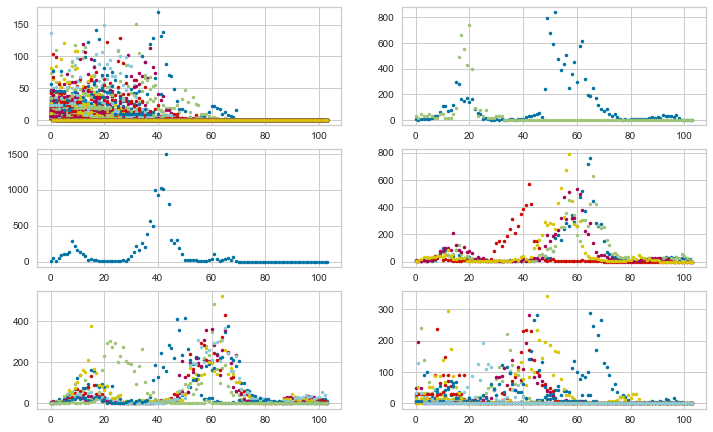

In [46]:
plt.figure(figsize=(12, 10))
model = aux2['Cluster KM'].values.tolist()

for j in list(range(6)):
    #print("J es: ", j)
    plt.subplot(4,2,j+1)
    #plt.title('Class = %s'%(),fontsize=20)
    for i in list(range(len(timeSeries))):
        #print("I es: ", i)
        if(model[i]==j):
            #print(timeSeries.loc[i,:].values)
            plt.plot(list(range(len(timeSeries.loc[i,:].values))), timeSeries.loc[i,:].values,'.')